In [2]:
import sys

import seaborn
from tensorflow.keras import datasets, layers, models, losses
import numpy as np
from PIL import Image
import tensorflow as tf
import torchvision as tv
import matplotlib.pyplot as plt
from livelossplot import PlotLossesKeras
import tensorflow_addons as tfa
from sklearn.metrics import confusion_matrix

sys.path.append('../../')

from core.datasets import get_ds, open_f
from core.make_answer import make_ans_file 
from core.ensembles import get_bagging_pred, print_bagging_ensemble_statistic, print_models_accuracy, get_ensemble_modelbase, get_modeset


C:\Users\Salam\AppData\Roaming\Python\Python310\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


- после небольшого исследования в качестве структурной основы была взята теория ансамбля типа bagging. Он относительно простой в реализации и должен существенно улучшить наш результат.

In [3]:
transformer = tv.transforms.Compose([
    tv.transforms.ColorJitter(brightness=.2, hue=0.2, contrast=0.5),
    tv.transforms.RandomAffine(degrees=(-10, 10), translate=(0, 0.1), scale=(0.85, 1)),
    tv.transforms.RandomPerspective(distortion_scale=0.2, p=0.7),
])

In [4]:
acc_test_ds = open_f("smote_data_train_5000", back=2)

In [5]:
acc_test_ds_y = acc_test_ds["labels"]
acc_test_ds_x = acc_test_ds["images"] / 255.

In [6]:
train_ds, val_ds, test_ds = get_ds('repaired_data_train', 'repaired_data_test', transform=transformer, one_hot=True, back=2)
val_ds_x = np.array([i[0] for i in val_ds.unbatch().as_numpy_iterator()])
val_ds_y = np.array([i[1] for i in val_ds.unbatch().as_numpy_iterator()])
val_ds_y = np.argmax(val_ds_y, axis=1)

In [7]:
model_1 = tf.keras.models.load_model(f'../checkpoints/model_g_1_categorical_accuracy.h5')
model_3 = tf.keras.models.load_model(f'../checkpoints/model_g_3_categorical_accuracy.h5')
model_smote = tf.keras.models.load_model(f'../checkpoints/model_s_smote_categorical_accuracy.h5')
model_c = tf.keras.models.load_model(f'../checkpoints/model_C_EN_1_categorical_accuracy.h5')
model_8 = tf.keras.models.load_model(f'../checkpoints/model_g_8_categorical_accuracy.h5')
model_11 = tf.keras.models.load_model(f'../checkpoints/model_g_11_categorical_accuracy.h5')
model_16 = tf.keras.models.load_model(f'../checkpoints/model_g_16_avg_categorical_accuracy.h5')

In [14]:
models = [model_1, model_smote, model_8, model_c, model_11, model_16]
names = ["model G1", "model SMOTE", "model G8", "model C1", "model G11", "model G16"]

modelbase = get_ensemble_modelbase(models=models, names=names, x_val=acc_test_ds_x)

In [15]:
selected_names = ["model G1", "model SMOTE", "model G8", "model C1", "model G11", "model G16"]
modelset = get_modeset(modelbase, selected_names)

- Было замечено что повышение итогового accuracy ансамбля на пару тысячных может на кегле увеличить результат на пару сотых или, напротив, уменьшить его. Так что не стоит делать выводы только по accuracy.
Стоит также учитывать структурные особенности нашего ансамбля.

In [16]:
print_models_accuracy(modelbase=modelbase, y_val=acc_test_ds_y)

ACCURACY SCORE
model G1: 0.9781
model SMOTE: 0.9915
model G8: 0.9859
model C1: 0.9719
model G11: 0.989
model G16: 0.943


In [19]:
y_test_acc_pred = print_bagging_ensemble_statistic(modelset=modelset, y_val=acc_test_ds_y)

ACCURACY SCORE

ensemble bagging: 0.9951


- Смотрим на ошибки ансамбля и то, к каким классам они относятся.

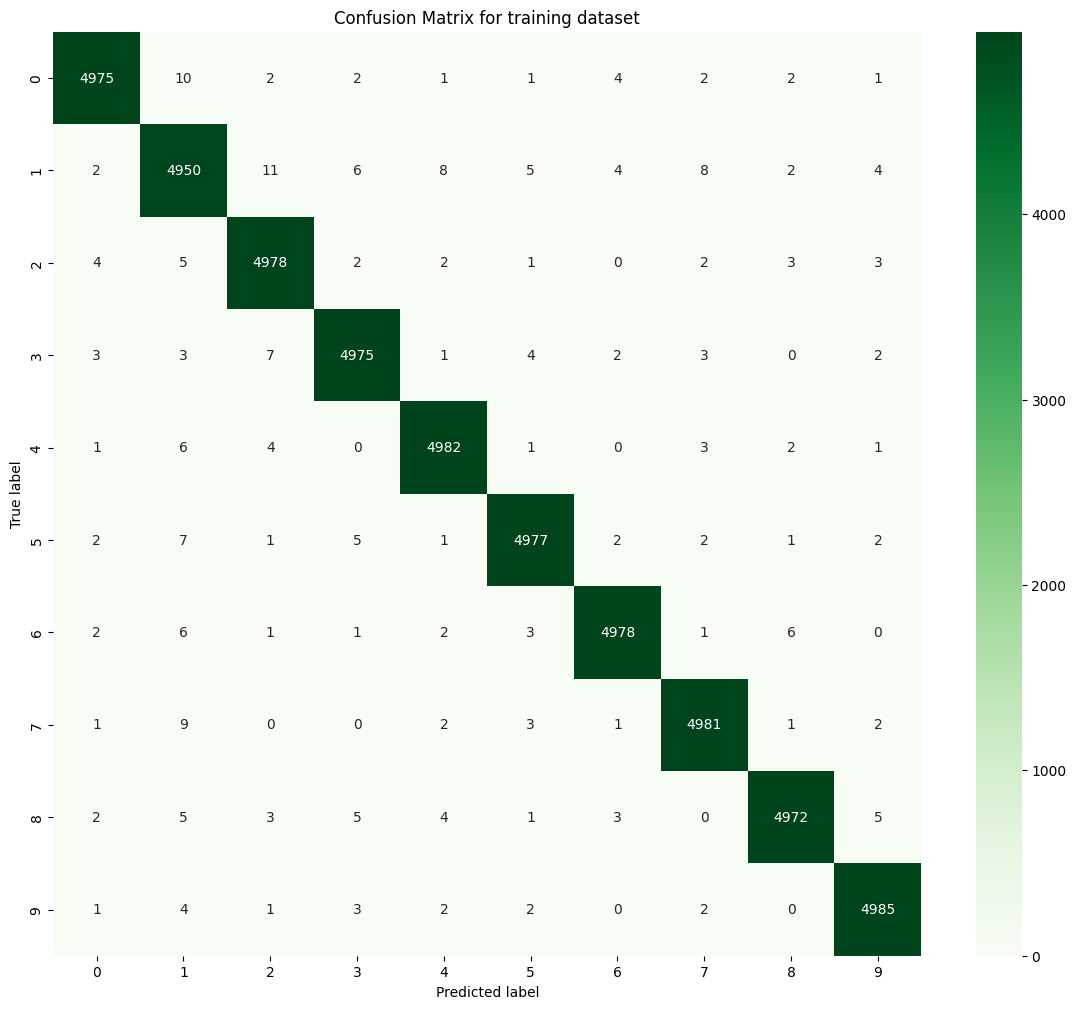

In [20]:
matrix = confusion_matrix(acc_test_ds_y, y_test_acc_pred)

fig, ax = plt.subplots(figsize=(14, 12))
seaborn.heatmap(matrix, annot=True, cmap='Greens', fmt='d', ax=ax)
plt.title('Confusion Matrix for training dataset')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

делаем тестовый предикт и сохраняем:

In [22]:
import pandas as pd
wunderwafel_test = get_bagging_pred(modelset=modelset, x_val=test_ds)

TypeError: get_bagging_pred() got an unexpected keyword argument 'x'

In [11]:
ensemble_model_name = "wunderwafel_b_test6"
ans = pd.DataFrame({'Id': np.arange(wunderwafel_test.shape[0]), 'Category': wunderwafel_test})
ans.to_csv(f"../answers/{ensemble_model_name}.csv", index=False)

- Было замечено, что количество моделей не коррелирует с итоговым accuracy, напротив, большое их количество негативно влияет на итоговый accuracy.

Вывод: техника ансамблей способна сильно повысить качество предиктов при правильном использовании. Необходимо продолжить их исследование.